In [90]:
#setup
data_dir='../../Data/Weather'
file_index='SSSSBBBB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [91]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


`%matplotlib` prevents importing * from pylab and numpy


In [92]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-4-a06a223af467>:4 

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2449.1| 36.0333|-105.8167|       SNWD|USC00299113|    15|[C4 5C F0 5B 00 7...|1948.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       SNWD|USC00299113|    35|[00 00 00 7E 00 7...|1949.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       SNWD|USC00299113|    13|[00 00 00 00 00 0...|1950.0|SSSSBBBB|
|   2094.9| 35.8333|-107.9167|       SNWD|USC00298562|    32|[00 00 00 00 00 0...|1970.0|SSSSBBBB|
|   2208.0| 35.6833|-105.9333|       SNWD|USC00298090|     9|[00 00 00 00 60 5...|1949.0|SSSSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

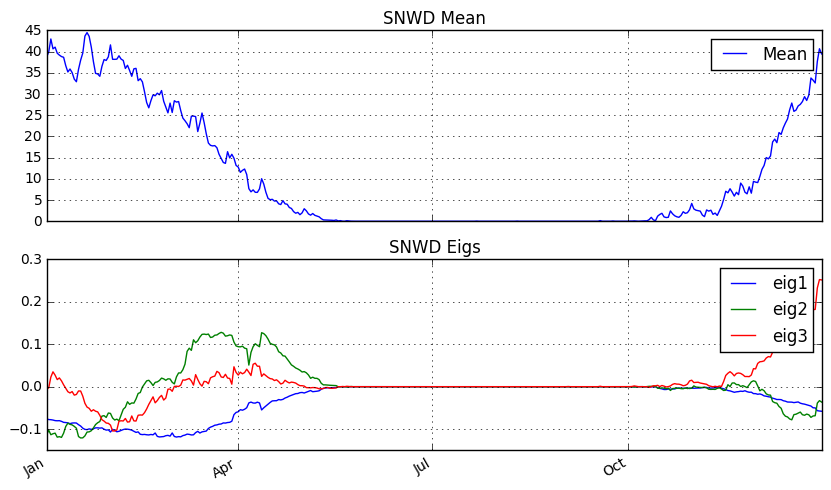

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

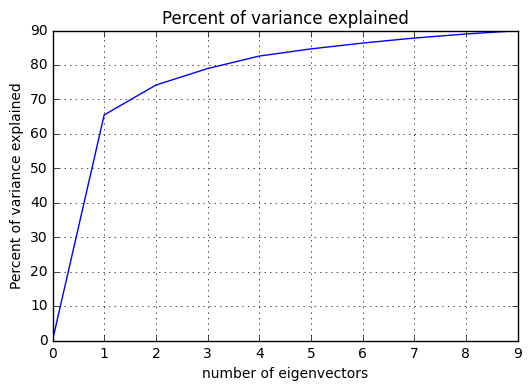

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1480
after filter 503


In [12]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [72]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j] if row_n>1 else axes[j],interactive=False,Title="c3=%0.2f, r3=%0.2f"%(row["coeff_3"],row["res_3"]))
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [75]:
dfn=df2.filter(df2.res_3<0.4).sort(df2.coeff_3,ascending=False)
rows=dfn.take(4)
dfn.select('coeff_3','res_3').show(4)

+------------------+--------------------+
|           coeff_3|               res_3|
+------------------+--------------------+
| 2110.031462399581| 0.20384994133204795|
|1699.8042226819086|0.054608372183170724|
|1594.3282282801692| 0.08848097180179113|
|1507.7025445150584| 0.24360643388890996|
+------------------+--------------------+
only showing top 4 rows



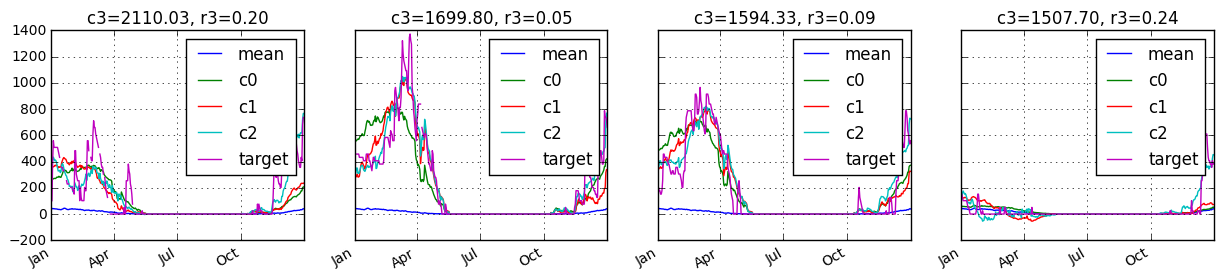

In [76]:
plot_recon_grid(rows,row_n=1,figsize=(15,3))

In [15]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+-------------------+--------------------+
|            coeff_2|               res_2|
+-------------------+--------------------+
|-2769.1932793368615| 0.12451708339710535|
|-2309.3414111954517|0.045165507547204976|
|-1626.8349955861947| 0.28214888202711796|
| -1476.565410818745|  0.3579730134695308|
+-------------------+--------------------+
only showing top 4 rows



d:\program files\anaconda2\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


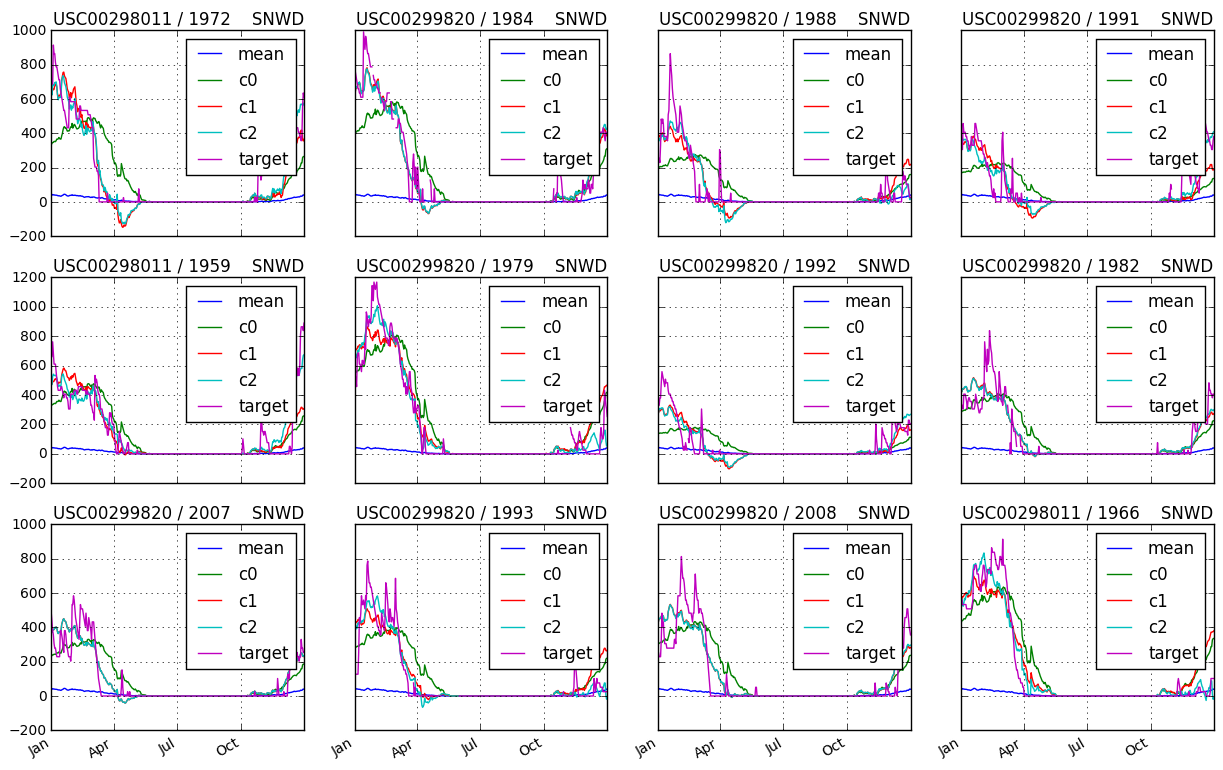

In [16]:
plot_recon_grid(rows)

In [17]:
df3.sort?

In [18]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
| 5577.455354460321| 0.1483301923921742|
|3431.7167004971284| 0.0664048887742429|
|2777.3350577571646|0.05862548991273176|
| 2425.790641129642| 0.1072346018198231|
+------------------+-------------------+
only showing top 4 rows



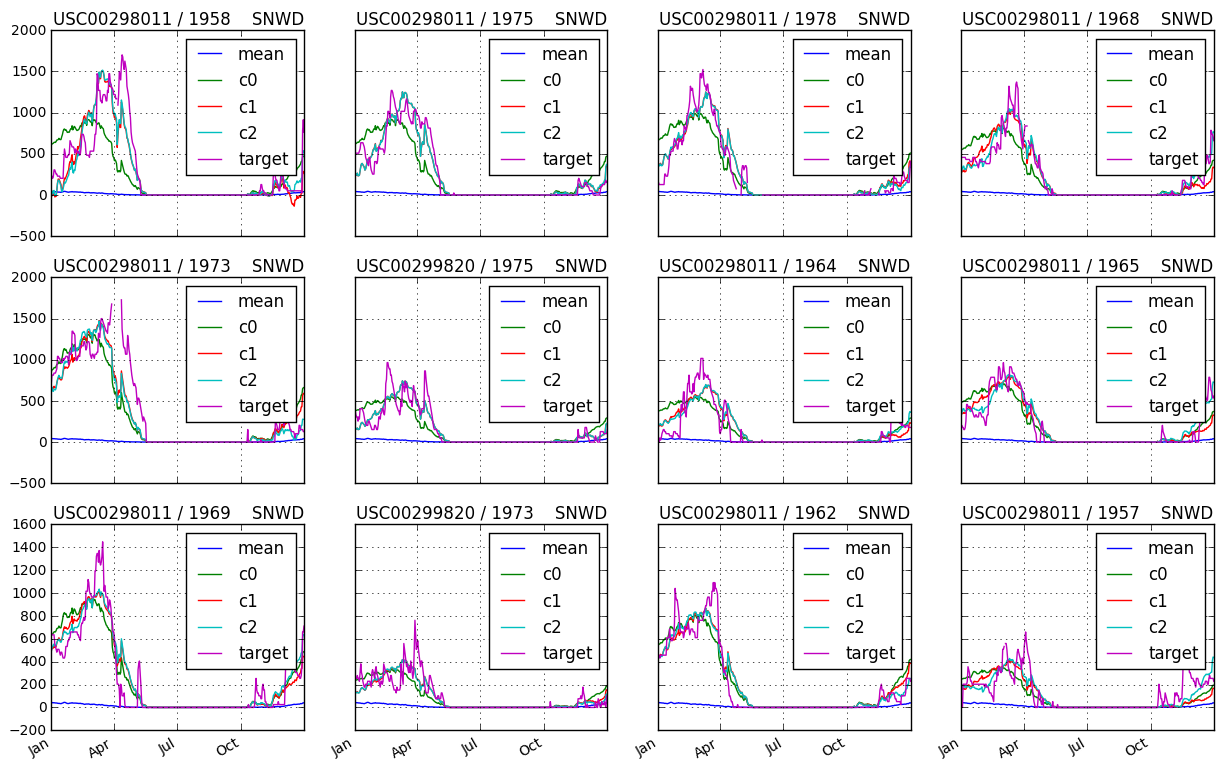

In [19]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.962998306416
residual normalized norm  after mean + top eigs: [ 0.4538615   0.14833019  0.1383008 ]


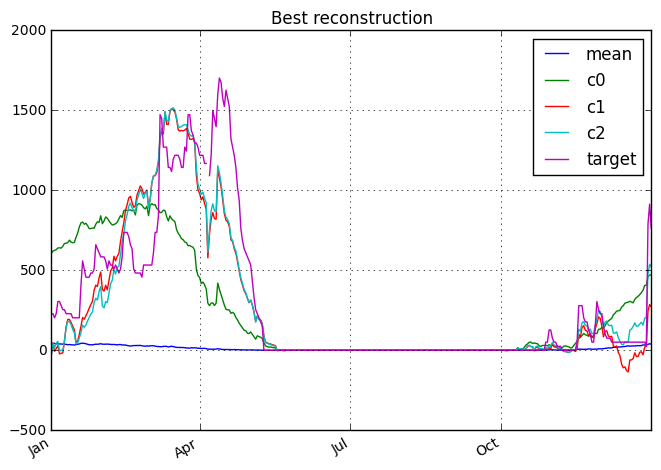

In [28]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [21]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

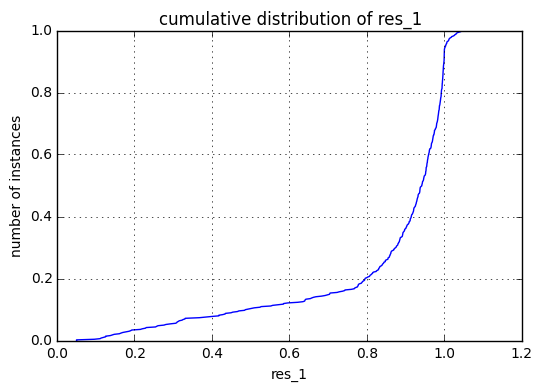

In [84]:
plot_CDF('res_1')

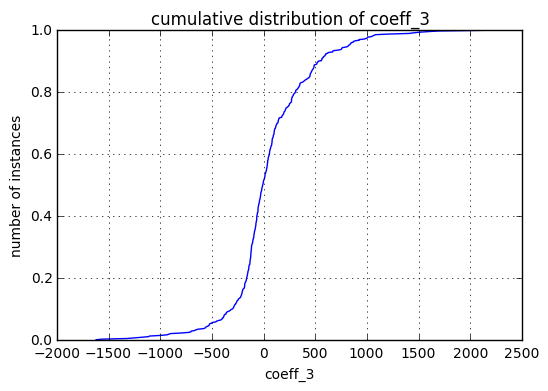

In [89]:
plot_CDF('coeff_3')

In [82]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df2.write.parquet(filename)

'rm' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [26]:
!du -sh $data_dir/*.parquet

'du' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
